# Transverse fied Ising model to demo primitives

In [42]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(0.5), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(YGate().inverse(), label=r"$\sqrt{Y}^\dag$")

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
  if num_cl_bits == 0:
    qc = QuantumCircuit(num_qubits)
  else:
    qc = QuantumCircuit(num_qubits, num_cl_bits)

  for trotter_step in range(num_trotter_steps):
    add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if(trotter_barriers):
      qc.barrier()

  return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
  
  # Adding Rzz in the even layers
  for i in range(0, qc.num_qubits-1, 2):
    qc.sdg([i,i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  if layer_barriers:
    qc.barrier()

  # Adding Rzz in the even layers
  for i in range(1, qc.num_qubits-1, 2):
    qc.sdg([i,i+1])
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
  if layer_barriers:
    qc.barrier()
  
  # Adding RX in the layers
  qc.rx(rx_angle, list(range(qc.num_qubits)))
  if layer_barriers:
    qc.barrier()


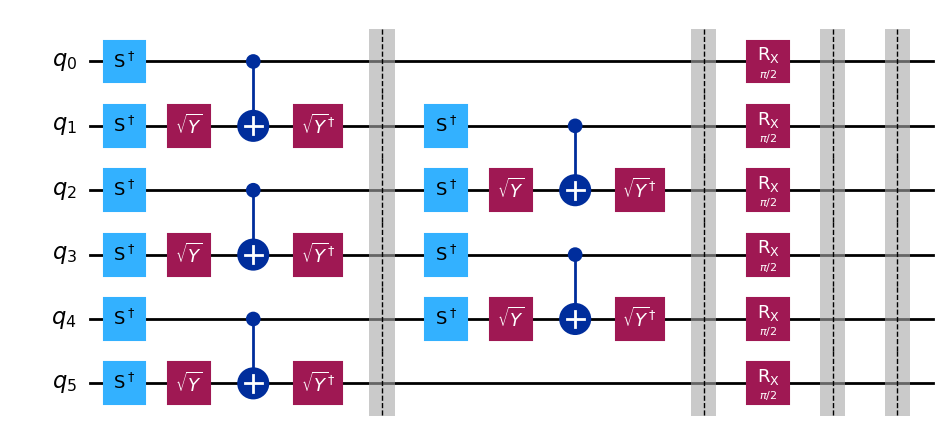

In [43]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

## Demo: Sampler

In [44]:
def append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):

  for trotter_step in range(num_trotter_steps):
    add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
    if(trotter_barriers):
      qc.barrier()

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):

  # Adding RX in the layers
  qc.rx(-rx_angle, list(range(qc.num_qubits)))
  if layer_barriers:
    qc.barrier()

  # Adding Rzz in the od layers
  for i in range(1, qc.num_qubits-1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.s([i,i+1])
  if layer_barriers:
    qc.barrier()
  
  # Adding RZZ in the odd layers
  for i in range(0, qc.num_qubits-1, 2):
    qc.append(SYGate, [i+1])
    qc.cx(i, i+1)
    qc.append(SYdgGate, [i+1])
    qc.s([i,i+1])
  if layer_barriers:
    qc.barrier()
  

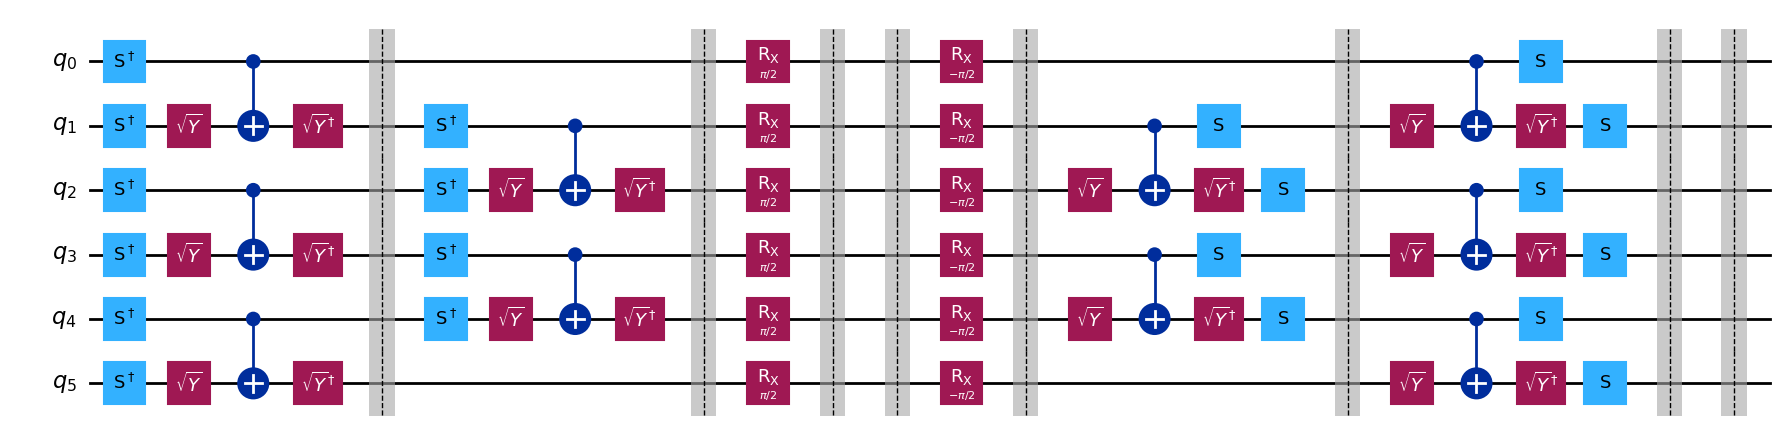

In [45]:
append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)

# Step 1: Mapt hte problem to circuits and oservables

In [46]:
max_trotter_steps = 10
num_qubits = 8
measured_qubits = [4,5]

qc_list=[]
for trotter_steps in range(max_trotter_steps):
  qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle,num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
  append_mirrored_id_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
  qc.measure(measured_qubits, list(range(len(measured_qubits))))
  qc_list.append(qc)

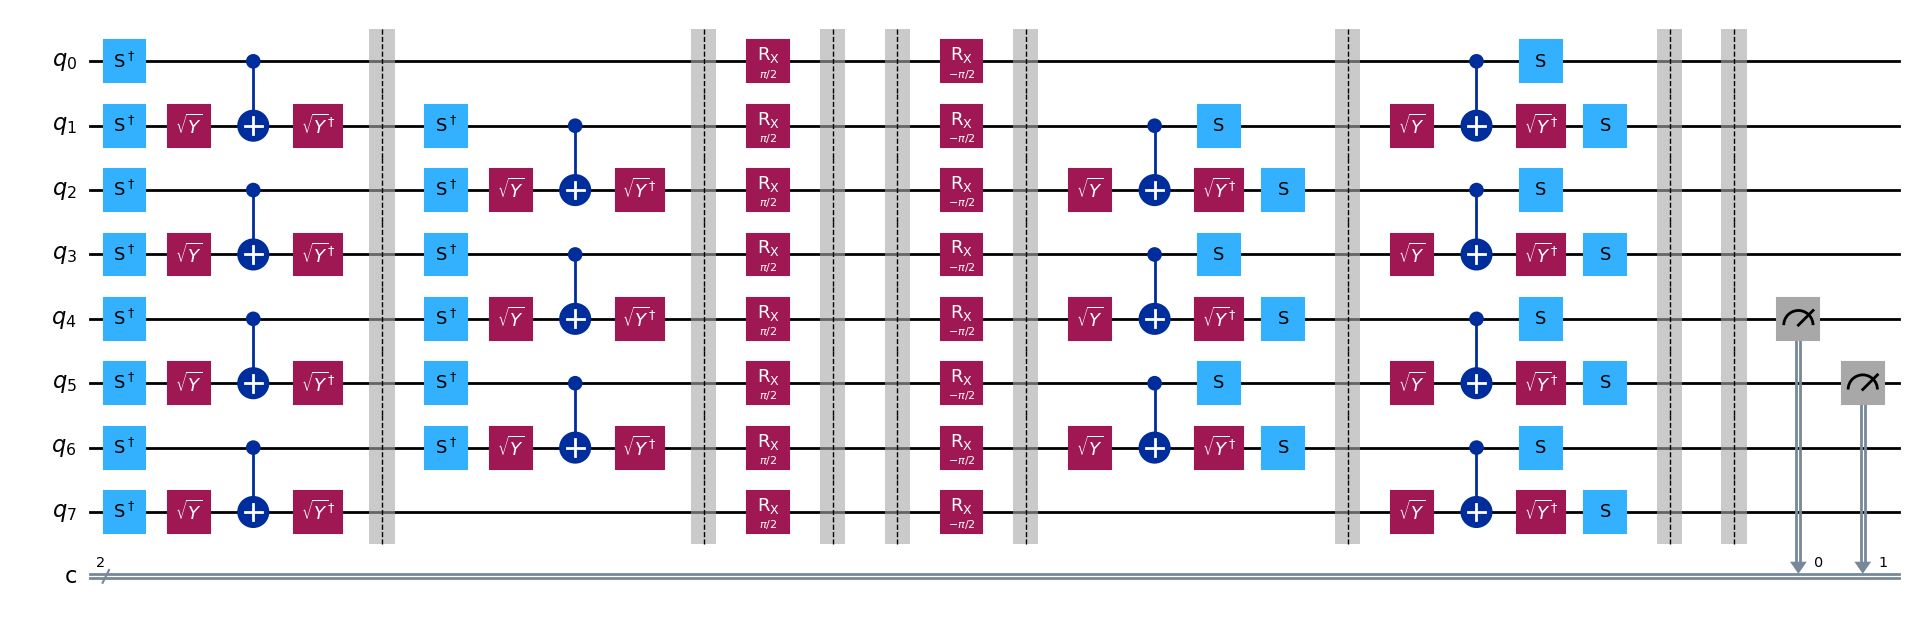

In [48]:
qc_list[1].draw(output='mpl', fold=-1)

# Step 2: Optimize

In [49]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print('Done getting the backend')

qc_transplied_list = transpile(qc_list, backend=backend, optimization_level=1)

Done getting the backend


# Step 3: Execute on hardware

In [51]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = 'XY4'

job = sampler.run(qc_transplied_list)
job_id = job.job_id()
print(job_id)

/tmp/ipykernel_1757/1386794160.py:3: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=backend)


csx7gbh7ynng008zkfpg


# Step 4: Post-processing and plotting

In [52]:
from qiskit_ibm_runtime import QiskitRuntimeService
job_id = 'csx7gbh7ynng008zkfpg'
service = QiskitRuntimeService()
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
  try:
    data = job.result()[trotter_step].data
    survival_probability_list.append(data.c.get_counts()[ * len(measured_qubits)] / data.c.num_shots)
  except:
    survival_probability_list.append(0)

In [2]:
import matplotlib.pyplot as plt

plt.plot(range(0, 4 * max_trotter_steps, 4), survival_probability_list, marker='--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 0))
plt.show()


NameError: name 'max_trotter_steps' is not defined

# Estimator

# Step 1: Mapping the problem